In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
import jax.numpy as jnp
import jax
import jax.tree_util as jtu
import genjax
from genjax import gen, Target, smc
from genjax import ChoiceMapBuilder as C
from config import *
from IPython.display import HTML
genjax.pretty()

from maskcombinator_model import multifirefly_model
from utils import *

# Testing a different observation model

Make sure that the observation model is `get_observed_blinks` and not the pixel based model before running this notebook.

In [2]:
key = jax.random.PRNGKey(777)
key, subkey = jax.random.split(key)
max_fireflies = jnp.arange(1, 5)

multi_model_jit = jax.jit(multifirefly_model.importance)
constraint = C["n_fireflies"].set(2) 
time_mask = jnp.arange(TIME_STEPS) < TIME_STEPS # Number of time steps to simulate
tr, w = multi_model_jit(subkey, constraint, (max_fireflies, time_mask,))

chm = tr.get_sample()
print(chm)

Static({'init': Indexed(c=Static({'blink_rate': Choice(v=Mask(value=<jax.Array float32(4,) ≈0.1 ±0.0075 [≥0.092, ≤0.11] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>)), 'vx': Choice(v=Mask(value=<jax.Array float32(4,) ≈0.28 ±1.1 [≥-1.6, ≤1.0] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>)), 'vy': Choice(v=Mask(value=<jax.Array float32(4,) ≈-0.64 ±0.51 [≥-1.4, ≤-0.06] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>)), 'x': Choice(v=Mask(value=<jax.Array float32(4,) ≈2.4e+01 ±9.2 [≥7.9, ≤3e+01] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>)), 'y': Choice(v=Mask(value=<jax.Array float32(4,) ≈1.4e+01 ±9.6 [≥4.5, ≤3e+01] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>))}), addr=None), 'steps': Indexed(c=Static({'dynamics': Indexed(c=Static({'blink': Choice(v=Mask(value=<jax.Array int32(20, 4) [≥0, ≤1] zero:64 nonzero:16>, flag=<jax.Array bool(20, 4) true:40 false:40>)), 'vx': Choice(v=Mask(value=<jax.Array float32(20, 4) ≈-0.44 ±1.1 [≥-2.0, ≤1.9] nonzero:80>, 

In [5]:
def get_observations(chm):
    observed_xs = chm["steps", :, "observations", "observed_xs"]
    observed_ys = chm["steps", :, "observations", "observed_ys"]

    observed_xs = observed_xs.value[:, :len(observed_xs.flag)]
    observed_ys = observed_ys.value[:, :len(observed_ys.flag)]
    return observed_xs, observed_ys


def get_gt_locations(chm):
    xs = chm["steps", :, "dynamics", :, "x"]
    ys = chm["steps", :, "dynamics", :, "y"]

    xs = jnp.where(xs.flag, xs.value, -1.)
    ys = jnp.where(ys.flag, ys.value, -1.)
    return xs, ys

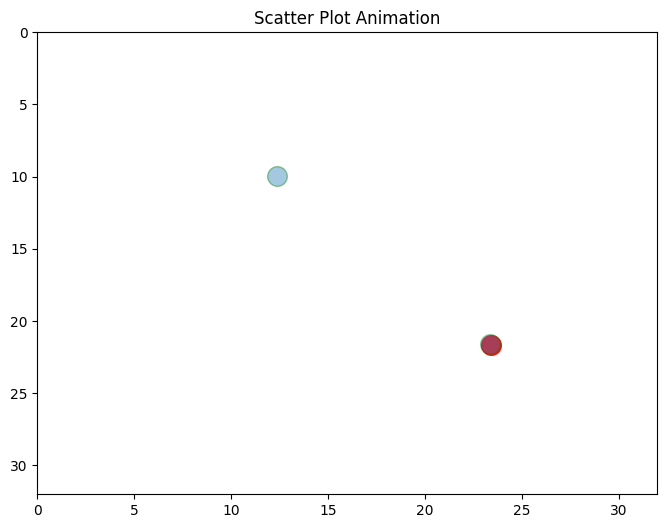

In [6]:
def scatter_animation(observed_xs, observed_ys, gt_xs=None, gt_ys=None):
    """
    Basic scatter plot animation with moving points
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, SCENE_SIZE)
    ax.set_ylim(SCENE_SIZE, 0)
    ax.set_title('Scatter Plot Animation')
    
    # Initialize scatter plot
    obs_scatter = ax.scatter([], [], c='red', s=200, alpha=0.9, animated=True)
    gt_scatter = ax.scatter([], [], edgecolors='green', facecolors=None, s=200, alpha=0.4, animated=True)

    # Animation update function
    def update(frame):
        # Generate random points
        xs = [x for x in observed_xs[frame, :] if x > 0]
        ys = [y for y in observed_ys[frame, :] if y > 0]
        # Update scatter plot data
        obs_scatter.set_offsets(np.column_stack([xs, ys]))

        if gt_xs is not None:
            xs = [x for x in gt_xs[frame, :] if x > 0]
            ys = [y for y in gt_ys[frame, :] if y > 0]
            gt_scatter.set_offsets(np.column_stack([xs, ys]))

        return obs_scatter, gt_scatter
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(observed_xs),  # Number of animation frames
        interval=100,  # Milliseconds between frames
        blit=True
    )
    
    return anim

observed_xs, observed_ys = get_observations(chm)
gt_xs, gt_ys = get_gt_locations(chm)

anim = scatter_animation(observed_xs, observed_ys, gt_xs, gt_ys)
HTML(anim.to_jshtml())

In [13]:
N = 20000
K = 100

def SIR(N, K, model, chm):
    @jax.jit
    def _inner(key, args):
        key, subkey = jax.random.split(key)
        traces, weights = jax.vmap(model.importance, in_axes=(0, None, None))(
            jax.random.split(key, N), chm, args
        )
        idxs = jax.vmap(jax.jit(genjax.categorical.simulate), in_axes=(0, None))(
            jax.random.split(subkey, K), (weights,)
        ).get_retval()
        samples = traces.get_sample()
        resampled_samples = jax.vmap(lambda idx: jtu.tree_map(lambda v: v[idx], samples))(
            idxs
        )
        return resampled_samples

    return _inner

In [14]:
def make_constraints(trace):
    observed_xs = trace["steps", :, "observations", "observed_xs"]
    observed_ys = trace["steps", :, "observations", "observed_ys"]
    constraints = C["steps", :, "observations", "observed_xs"].set(observed_xs) ^ \
            C["steps", :, "observations", "observed_ys"].set(observed_ys)
    return constraints

In [17]:
constraints = make_constraints(chm)
args = (max_fireflies, time_mask,)
key = 12094323
key = jax.random.PRNGKey(key)
samples = jax.jit(SIR(N, K, multifirefly_model, constraints))(key, args)

In [19]:
samples["n_fireflies"].mean(), samples["n_fireflies"].std()

(<jax.Array(2., dtype=float32)>, <jax.Array(0., dtype=float32)>)

In [20]:
def scatter_multiple_animation(observed_xs, observed_ys, gt_xs=None, gt_ys=None):
    """
    Basic scatter plot animation with moving points
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, SCENE_SIZE)
    ax.set_ylim(SCENE_SIZE, 0)
    ax.set_title('Scatter Plot Animation')
    
    # Initialize scatter plot
    obs_scatter = ax.scatter([], [], c='red', s=200, alpha=0.9, animated=True)
    gt_scatter = ax.scatter([], [], edgecolors='green', facecolors=None, s=200, alpha=0.4, animated=True)

    # Animation update function
    def update(frame):
        # Generate random points
        xs = observed_xs[:, frame, :].flatten()
        ys = observed_ys[:, frame, :].flatten()
        # Update scatter plot data
        obs_scatter.set_offsets(np.column_stack([xs, ys]))

        if gt_xs is not None:
            xs = [x for x in gt_xs[frame, :] if x > 0]
            ys = [y for y in gt_ys[frame, :] if y > 0]
            gt_scatter.set_offsets(np.column_stack([xs, ys]))

        return obs_scatter, gt_scatter
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=observed_xs.shape[1],  # Number of animation frames
        interval=100,  # Milliseconds between frames
        blit=True
    )
    
    return anim

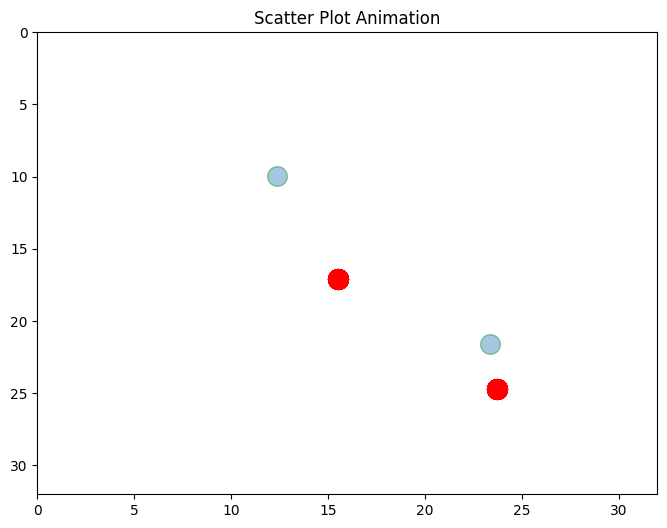

In [21]:
sampled_xs, sampled_ys = get_gt_locations(samples)

anim = scatter_multiple_animation(sampled_xs, sampled_ys, gt_xs, gt_ys)
HTML(anim.to_jshtml())

(100, 20, 4)